# Project 1 - Text Questions Classification: 
## Classify a Given Question Text to One of the Six Categories

Description: https://docs.google.com/document/d/14YP8_z1iH4X_eg9wY1HN57HGxlpT53YFMdbe8GeZNUk/edit?usp=sharing

## 1. Spacy Tests

In [2]:
import re

In [31]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc = nlp(u"This is a bad sentence greatly.")

print([(w.text, w.pos_) for w in doc])

[('This', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('bad', 'ADJ'), ('sentence', 'NOUN'), ('greatly', 'ADV'), ('.', 'PUNCT')]


In [172]:
doc = nlp(u"What am I a bad sentence of the U.S. greatly in here?")
print([(w.text, w.pos_) for w in doc])
Counter([t.text for t in doc if t.pos_ not in ['DET', 'PUNCT']])

[('What', 'PRON'), ('am', 'VERB'), ('I', 'PRON'), ('a', 'DET'), ('bad', 'ADJ'), ('sentence', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'PROPN'), ('greatly', 'ADV'), ('in', 'ADP'), ('here', 'ADV'), ('?', 'PUNCT')]


Counter({'What': 1,
         'am': 1,
         'I': 1,
         'bad': 1,
         'sentence': 1,
         'of': 1,
         'U.S.': 1,
         'greatly': 1,
         'in': 1,
         'here': 1})

In [4]:
type(nlp)

spacy.lang.en.English

In [5]:
type(doc)

spacy.tokens.doc.Doc

## 2. Data Prepration
#### Output: A DataFrame of questions, labels, and sublabels.

**use the largest training dataset for 5000

In [6]:
import codecs
from collections import defaultdict
import pandas as pd

file_name = "train_5500.label"

with open(file_name, 'rb') as f:
    txt = f.read()

lines = txt.decode('latin').splitlines()

#for idx, line in enumerate(lines):
 #   print(line)

In [15]:
df = []
for idx, line in enumerate(lines):
    match = re.match('([A-Z]+)\:([a-z]+)[ ]+(.+)',line)
    #print(match.groups())
    df.append(match.groups())

df = pd.DataFrame(df, columns = ['label', 'sublabel','question'])

print(df.head())

  label sublabel                                           question
0  DESC   manner  How did serfdom develop in and then leave Russ...
1  ENTY   cremat   What films featured the character Popeye Doyle ?
2  DESC   manner  How can I find a list of celebrities ' real na...
3  ENTY   animal  What fowl grabs the spotlight after the Chines...
4  ABBR      exp                    What is the full form of .com ?


### 2.1 NLP: Word2Vec
#### Output: A DataFrame of document vectors

In [8]:
nlp = spacy.load('en_core_web_lg')

vectors = []

for idx, row in df.iterrows():
    doc = nlp(row['question'])
    vectors.append(pd.DataFrame([t.vector for t in doc]).mean())
    #print(pd.DataFrame([t.vector for t in doc]).mean())

df_vec = pd.DataFrame(vectors)
print(df_vec.head())

        0         1         2         3         4         5         6    \
0 -0.095385  0.145313 -0.102526 -0.034010  0.075759 -0.141677  0.066431   
1  0.056004  0.079700  0.017709 -0.136104  0.157276  0.166497  0.065532   
2 -0.069375  0.152507 -0.249951 -0.120486  0.298487  0.019549  0.197415   
3 -0.062719 -0.012321 -0.038860 -0.120913  0.022380  0.007823  0.077755   
4  0.072690  0.114806 -0.159714 -0.006696  0.113063 -0.132307  0.162451   

        7         8         9    ...       290       291       292       293  \
0 -0.084729  0.013960  2.117576  ... -0.096183  0.159912  0.111225 -0.058195   
1 -0.085842 -0.032438  1.450033  ... -0.155592 -0.078499 -0.215343  0.130424   
2 -0.165814  0.029086  2.123617  ... -0.190413  0.026192 -0.060264 -0.056614   
3 -0.024781  0.101000  1.992542  ... -0.164768  0.041619 -0.083150 -0.126231   
4  0.003159 -0.033583  1.786263  ... -0.097932 -0.127476  0.085656 -0.251220   

        294       295       296       297       298       299  
0  0

## 3. ML Modelling
### 3.1 Logistic Regression: Main Lable Classification

#### 3.1.1 Training

In [84]:
#import sklearn
from sklearn.model_selection import train_test_split
vec_train, vec_test, label_train, label_test = train_test_split(
    df_vec,df['label'],test_size=0.25,random_state=0, stratify=df['label'])

In [85]:
#import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

# fit the model with data
logreg.fit(vec_train,label_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### 3.1.2 Inference

In [86]:
# Predictions
label_pred_test = logreg.predict(vec_test)
label_pred_train = logreg.predict(vec_train)

#### 3.1.3 Modelling Performance
#### Confusion Matrix, Accuracy, Precision, Recall, and F1 Score

In [87]:
classes = list(set(label_test))

print(classes)

['HUM', 'DESC', 'ENTY', 'LOC', 'ABBR', 'NUM']


In [88]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(label_test, label_pred_test, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix)

Note: Columns (predictions) vs. Rows (actuals)

      HUM  DESC  ENTY  LOC  ABBR  NUM
HUM   234    10    28   20     1   13
DESC    7   195    42   14     2   30
ENTY   28    43   206   16     1   18
LOC     7     8    11  174     0    9
ABBR    1     8     2    0    11    0
NUM    10     9    17    9     0  179


In [89]:
accuracy = metrics.accuracy_score(label_test, label_pred_test)
precision_score = metrics.precision_score(label_test, label_pred_test, average='macro', labels=classes)
recall_score = metrics.recall_score(label_test, label_pred_test, average='macro', labels=classes)
f1_score = metrics.f1_score(label_test, label_pred_test, average='macro',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.7329420396184886
Precision: 0.7336348817231592
Recall: 0.7048365189562346
Unweighted Average F1 Score: 0.7145646030354024


In [90]:
accuracy = metrics.accuracy_score(label_train, label_pred_train)
precision_score = metrics.precision_score(label_train, label_pred_train, average='macro', labels=classes)
recall_score = metrics.recall_score(label_train, label_pred_train, average='macro', labels=classes)
f1_score = metrics.f1_score(label_train, label_pred_train, average='macro',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.7960381511371973
Precision: 0.7979020724878502
Recall: 0.8179901614244671
Unweighted Average F1 Score: 0.8069571613766264


**To compute the metrics on the training data as well

### 3.2 Logistic Regression: Sublabel Classification

In [91]:
vec_train, vec_test, sublabel_train, sublabel_test = train_test_split(
    df_vec,df['sublabel'],test_size=0.25,random_state=0, stratify=df['sublabel'])

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

# fit the model with data
logreg.fit(vec_train,sublabel_train)

# Predictions
sublabel_pred_test = logreg.predict(vec_test)
sublabel_pred_train = logreg.predict(vec_train)


In [92]:
classes = list(set(sublabel_test))

print(classes)

['abb', 'event', 'weight', 'cremat', 'exp', 'volsize', 'period', 'dist', 'body', 'symbol', 'city', 'title', 'speed', 'religion', 'instru', 'plant', 'techmeth', 'desc', 'reason', 'lang', 'def', 'currency', 'food', 'termeq', 'manner', 'money', 'mount', 'ord', 'other', 'word', 'veh', 'date', 'substance', 'country', 'ind', 'product', 'letter', 'sport', 'count', 'dismed', 'color', 'perc', 'animal', 'state', 'temp', 'gr', 'code']


In [93]:
cnf_matrix = metrics.confusion_matrix(sublabel_test, sublabel_pred_test, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix)

Note: Columns (predictions) vs. Rows (actuals)

           abb  event  weight  cremat  exp  volsize  period  dist  body  \
abb          4      0       0       0    0        0       0     0     0   
event        1      6       0       1    0        0       0     0     0   
weight       0      0       2       0    0        0       0     0     0   
cremat       0      3       0      38    0        0       0     0     0   
exp          1      0       0       1   10        0       0     0     0   
volsize      0      0       0       0    0        3       0     0     0   
period       0      0       0       0    0        0      16     1     0   
dist         0      0       0       0    0        1       2     3     0   
body         0      0       0       0    0        0       0     0     2   
symbol       0      0       0       0    0        0       0     0     0   
city         0      1       0       0    0        0       0     0     0   
title        0      0       0       0    0        0 

In [94]:
accuracy = metrics.accuracy_score(sublabel_test, sublabel_pred_test)
precision_score = metrics.precision_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
recall_score = metrics.recall_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
f1_score = metrics.f1_score(sublabel_test, sublabel_pred_test, average='weighted',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.6434336023477623
Precision: 0.6835061732984642
Recall: 0.6434336023477623
Unweighted Average F1 Score: 0.6427312983395492


In [95]:
accuracy = metrics.accuracy_score(sublabel_train, sublabel_pred_train)
precision_score = metrics.precision_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
recall_score = metrics.recall_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
f1_score = metrics.f1_score(sublabel_train, sublabel_pred_train, average='weighted',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.7583761310833945
Precision: 0.790537004632156
Recall: 0.7583761310833945
Unweighted Average F1 Score: 0.7538890365455875


### 3.3 Logistic Regression: Conditional Classification

In [96]:
for lb in ['ABBR', 'HUM', 'DESC', 'NUM', 'LOC', 'ENTY']:
    
    vec_train, vec_test, sublabel_train, sublabel_test = train_test_split(
        df_vec[df['label']==lb],df[df['label']==lb]['sublabel'],
        test_size=0.25,random_state=0,stratify=df[df['label']==lb]['sublabel'])

    # instantiate the model (using the default parameters)
    logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

    # fit the model with data
    logreg.fit(vec_train,sublabel_train)

    # Predictions
    sublabel_pred_test = logreg.predict(vec_test)
    sublabel_pred_train = logreg.predict(vec_train)

    classes = list(set(sublabel_test))

    cnf_matrix = metrics.confusion_matrix(sublabel_test, sublabel_pred_test, labels=classes)
    cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
    cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

    print("\n------------------ ",lb," --------------------\n")
    print("Note: Columns (predictions) vs. Rows (actuals)\n")
    print(cnf_matrix,'\n')

    accuracy = metrics.accuracy_score(sublabel_test, sublabel_pred_test)
    precision_score = metrics.precision_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
    recall_score = metrics.recall_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
    f1_score = metrics.f1_score(sublabel_test, sublabel_pred_test, average='weighted',labels=classes)

    print("\n------------------ Test --------------------\n")
    print("Accuracy:", accuracy)
    print("Precision:", precision_score)
    print("Recall:", recall_score)
    print("Unweighted Average F1 Score:", f1_score)
    
    accuracy = metrics.accuracy_score(sublabel_train, sublabel_pred_train)
    precision_score = metrics.precision_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
    recall_score = metrics.recall_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
    f1_score = metrics.f1_score(sublabel_train, sublabel_pred_train, average='weighted',labels=classes)

    print("\n------------------ Train --------------------\n")
    print("Accuracy:", accuracy)
    print("Precision:", precision_score)
    print("Recall:", recall_score)
    print("Unweighted Average F1 Score:", f1_score)


------------------  ABBR  --------------------

Note: Columns (predictions) vs. Rows (actuals)

     abb  exp
abb    4    0
exp    1   17 


------------------ Test --------------------

Accuracy: 0.9545454545454546
Precision: 0.9636363636363636
Recall: 0.9545454545454546
Unweighted Average F1 Score: 0.9564213564213564

------------------ Train --------------------

Accuracy: 0.984375
Precision: 0.9855769230769231
Recall: 0.984375
Unweighted Average F1 Score: 0.9846116504854369

------------------  HUM  --------------------

Note: Columns (predictions) vs. Rows (actuals)

       desc  ind  gr  title
desc     11    1   0      0
ind       0  232   8      1
gr        0   10  36      1
title     0    2   0      4 


------------------ Test --------------------

Accuracy: 0.9248366013071896
Precision: 0.9237476808905379
Recall: 0.9248366013071896
Unweighted Average F1 Score: 0.9240379380254977

------------------ Train --------------------

Accuracy: 0.9563794983642312
Precision: 0.9565898

/Users/Nima/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nima/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2-stage model: first Pr(main labels) -> add to the vector -> 306 dimension -> new logistic model

### 3.4 Decision Tree: Main Labels

In [97]:
from sklearn.tree import DecisionTreeClassifier 

vec_train, vec_test, label_train, label_test = train_test_split(
    df_vec,df['label'],test_size=0.25,random_state=0, stratify=df['label'])

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')

# Train Decision Tree Classifer
clf = clf.fit(vec_train,label_train)

#Predict the response for test dataset
label_pred_test = clf.predict(vec_test)
label_pred_train = clf.predict(vec_train)

accuracy = metrics.accuracy_score(label_test, label_pred_test)
print("\n------------------ Test --------------------\n")
print("Accuracy:", accuracy)

accuracy = metrics.accuracy_score(label_train, label_pred_train)
print("\n------------------ Train --------------------\n")
print("Accuracy:", accuracy)


------------------ Test --------------------

Accuracy: 0.43066764490095377

------------------ Train --------------------

Accuracy: 0.9975544142822206


Explainable but Random forest is better for modelling
Find out key dimensions

### 3.5 Performance Comparison

### 3.5.1 **1000 data samples**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels |
|-----|--------|--------|--------|--------|
|Accuracy| 0.684 | 0.544 | 0.443 - 0.854 | 0.384 |
 

 **Observation:** Poor calssification performance of ENTY sublabels given the main label, i.e., ENTY.

**Conditioanl Classification**


|   | ABBR | HUM | DESC | NUM | LOC | ENTY|
|---|---|---|---|---|---|---|
|Accuracy| 0.800 | 0.854 | 0.755 | 0.737 | 0.692 | 0.443 |

### 3.5.2 **5452 data samples**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels |
|-----|--------|--------|--------|--------|
|Accuracy| 0.743 | 0.650 | 0.689 - 0.909 | 0.428 |
 

 **Observation:** Poor calssification performance of ENTY sublabels given the main label, i.e., ENTY.

 **Conditioanl Classification**


|   | ABBR | HUM | DESC | NUM | LOC | ENTY|
|---|---|---|---|---|---|---|
|Accuracy| 0.909 | 0.882 | 0.818 | 0.808 | 0.899 | 0.687 |

### 3.5.3 **5452 data samples, Balanced training and Stratified sets**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels |
|-----|--------|--------|--------|--------|
|Accuracy| 0.733 | 0.643 | 0.716 - 0.954 | 0.440 |
 

 **Observation:** Poor calssification performance of ENTY sublabels given the main label, i.e., ENTY.

 **Conditioanl Classification**


|   | ABBR | HUM | DESC | NUM | LOC | ENTY|
|---|---|---|---|---|---|---|
|Accuracy| 0.954 | 0.925 | 0.859 | 0.844 | 0.919 | 0.716 |

- vertical form: how long it takes to train. 
- F1
- imbalanced dataset
- balanced = true , or auto
- Stratified train test split
- oversampling: repeating the infrequent test data

Next Step- USE (just encoder)
BERT (enc/dec) - generate sentence

## 4. USE

### 4.1 Vector Generation

In [135]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
messages = list(df['question'])

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0917 18:10:42.678633 4535920064 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [50]:
message_embeddings.shape

(5452, 512)

### 4.2 Logistic Regression: Main Lable Classification

In [98]:
#import sklearn
from sklearn.model_selection import train_test_split
vec_train, vec_test, label_train, label_test = train_test_split(
    message_embeddings,df['label'],test_size=0.25,random_state=0, stratify=df['label'])

#import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

# fit the model with data
logreg.fit(vec_train,label_train)

# Predictions
label_pred_test = logreg.predict(vec_test)
label_pred_train = logreg.predict(vec_train)

In [99]:
classes = list(set(label_test))

# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(label_test, label_pred_test, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix)


Note: Columns (predictions) vs. Rows (actuals)

      HUM  DESC  ENTY  LOC  ABBR  NUM
HUM   284     3    10    8     0    1
DESC    2   260    13    6     1    8
ENTY   18    21   253    7     1   12
LOC     1     5     5  198     0    0
ABBR    0     7     0    0    15    0
NUM     0     0     4    0     0  220


In [102]:
accuracy = metrics.accuracy_score(label_test, label_pred_test)
precision_score = metrics.precision_score(label_test, label_pred_test, average='macro', labels=classes)
recall_score = metrics.recall_score(label_test, label_pred_test, average='macro', labels=classes)
f1_score = metrics.f1_score(label_test, label_pred_test, average='macro',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.9024211298606016
Precision: 0.899428469727431
Recall: 0.874480532535406
Unweighted Average F1 Score: 0.8842112906805695


In [103]:
accuracy = metrics.accuracy_score(label_train, label_pred_train)
precision_score = metrics.precision_score(label_train, label_pred_train, average='macro', labels=classes)
recall_score = metrics.recall_score(label_train, label_pred_train, average='macro', labels=classes)
f1_score = metrics.f1_score(label_train, label_pred_train, average='macro',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.9024211298606016
Precision: 0.887394618909599
Recall: 0.8990734931695838
Unweighted Average F1 Score: 0.8928597004005728


### 4.3 Logistic Regression: Sublabel Classification

In [104]:
vec_train, vec_test, sublabel_train, sublabel_test = train_test_split(
    message_embeddings,df['sublabel'],test_size=0.25,random_state=0,stratify=df['sublabel'])

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

# fit the model with data
logreg.fit(vec_train,sublabel_train)

# Predictions
sublabel_pred_test = logreg.predict(vec_test)
sublabel_pred_train = logreg.predict(vec_train)

classes = list(set(sublabel_test))

cnf_matrix = metrics.confusion_matrix(sublabel_test, sublabel_pred_test, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix,"\n")

accuracy = metrics.accuracy_score(sublabel_test, sublabel_pred_test)
precision_score = metrics.precision_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
recall_score = metrics.recall_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
f1_score = metrics.f1_score(sublabel_test, sublabel_pred_test, average='weighted',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Note: Columns (predictions) vs. Rows (actuals)

           abb  event  weight  cremat  exp  volsize  period  dist  body  \
abb          2      0       0       0    2        0       0     0     0   
event        0     10       0       1    0        0       0     0     0   
weight       0      0       2       0    0        0       0     0     0   
cremat       0      1       0      44    0        0       0     0     0   
exp          0      0       0       0   14        0       0     0     0   
volsize      0      0       0       0    0        3       0     0     0   
period       0      0       0       0    0        0      17     1     0   
dist         0      0       0       0    0        0       2     5     0   
body         0      0       0       0    0        0       0     0     4   
symbol       0      0       0       0    0        0       0     0     0   
city         0      0       0       0    0        0       0     0     0   
title        0      0       0       0    0        0 

In [105]:
accuracy = metrics.accuracy_score(sublabel_train, sublabel_pred_train)
precision_score = metrics.precision_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
recall_score = metrics.recall_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
f1_score = metrics.f1_score(sublabel_train, sublabel_pred_train, average='weighted',labels=classes)

print("Accuracy:", accuracy)
print("Precision:", precision_score)
print("Recall:", recall_score)
print("Unweighted Average F1 Score:", f1_score)

Accuracy: 0.7669356810956224
Precision: 0.8118826901826869
Recall: 0.7669356810956224
Unweighted Average F1 Score: 0.7559292701867321


### 4.4 Logistic Regression: Conditional Classification

In [106]:
for lb in ['ABBR', 'HUM', 'DESC', 'NUM', 'LOC', 'ENTY']:
    
    vec_train, vec_test, sublabel_train, sublabel_test = train_test_split(
        message_embeddings[df['label']==lb],df[df['label']==lb]['sublabel'],
        test_size=0.25,random_state=0, stratify=df[df['label']==lb]['sublabel'])

    # instantiate the model (using the default parameters)
    logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

    # fit the model with data
    logreg.fit(vec_train,sublabel_train)

    # Predictions
    sublabel_pred_test = logreg.predict(vec_test)
    sublabel_pred_train = logreg.predict(vec_train)

    classes = list(set(sublabel_test))

    cnf_matrix = metrics.confusion_matrix(sublabel_test, sublabel_pred_test, labels=classes)
    cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
    cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

    print("\n------------------ ",lb," --------------------\n")
    print("Note: Columns (predictions) vs. Rows (actuals)\n")
    print(cnf_matrix,'\n')

    accuracy = metrics.accuracy_score(sublabel_test, sublabel_pred_test)
    precision_score = metrics.precision_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
    recall_score = metrics.recall_score(sublabel_test, sublabel_pred_test, average='weighted', labels=classes)
    f1_score = metrics.f1_score(sublabel_test, sublabel_pred_test, average='weighted',labels=classes)

    print("\n------------------ Test --------------------\n")
    print("Accuracy:", accuracy)
    print("Precision:", precision_score)
    print("Recall:", recall_score)
    print("Unweighted Average F1 Score:", f1_score)
    
    accuracy = metrics.accuracy_score(sublabel_train, sublabel_pred_train)
    precision_score = metrics.precision_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
    recall_score = metrics.recall_score(sublabel_train, sublabel_pred_train, average='weighted', labels=classes)
    f1_score = metrics.f1_score(sublabel_train, sublabel_pred_train, average='weighted',labels=classes)

    print("\n------------------ Train --------------------\n")
    print("Accuracy:", accuracy)
    print("Precision:", precision_score)
    print("Recall:", recall_score)
    print("Unweighted Average F1 Score:", f1_score)


------------------  ABBR  --------------------

Note: Columns (predictions) vs. Rows (actuals)

     abb  exp
abb    4    0
exp    4   14 


------------------ Test --------------------

Accuracy: 0.8181818181818182
Precision: 0.9090909090909091
Recall: 0.8181818181818182
Unweighted Average F1 Score: 0.8371212121212122

------------------ Train --------------------

Accuracy: 0.984375
Precision: 0.9855769230769231
Recall: 0.984375
Unweighted Average F1 Score: 0.9846116504854369

------------------  HUM  --------------------

Note: Columns (predictions) vs. Rows (actuals)

       desc  ind  gr  title
desc     10    2   0      0
ind       1  235   5      0
gr        0    3  44      0
title     0    2   0      4 


------------------ Test --------------------

Accuracy: 0.9575163398692811
Precision: 0.9579807129463355
Recall: 0.9575163398692811
Unweighted Average F1 Score: 0.9569659264672052

------------------ Train --------------------

Accuracy: 0.9574700109051254
Precision: 0.9579141

### 4.5 Decision Tree: Main Labels

In [110]:
from sklearn.tree import DecisionTreeClassifier 

vec_train, vec_test, label_train, label_test = train_test_split(
    message_embeddings,df['label'],test_size=0.25,random_state=0, stratify=df['label'])

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')

# Train Decision Tree Classifer
clf = clf.fit(vec_train,label_train)

#Predict the response for test dataset
label_pred_test = clf.predict(vec_test)
label_pred_train = clf.predict(vec_train)

accuracy = metrics.accuracy_score(label_test, label_pred_test)
print("\n------------------ Test --------------------\n")
print("Accuracy:", accuracy)

accuracy = metrics.accuracy_score(label_train, label_pred_train)
print("\n------------------ Train --------------------\n")
print("Accuracy:", accuracy)


------------------ Test --------------------

Accuracy: 0.7182685253118122

------------------ Train --------------------

Accuracy: 1.0


### 4.6 Performance

#### 4.6.1 **Accuracy - 5452 data samples**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels |
|-----|--------|--------|--------|--------|
|Spacy| 0.743 | 0.650 | 0.689 - 0.909 | 0.428 |
|USE| 0.896 | 0.728 | 0.712 - 0.895 | 0.717 |
 

 **Conditioanl Classification**


|   | ABBR | HUM | DESC | NUM | LOC | ENTY|
|---|---|---|---|---|---|---|
|Spacy| 0.909 | 0.882 | 0.818 | 0.808 | 0.899 | 0.687 |
|USE| 0.727 | 0.895 | 0.835 | 0.790 | 0.885 | 0.712 |

#### 4.6.2 **Accuracy - 5452 data samples, Balanced/Stratified**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels |
|-----|--------|--------|--------|--------|
|Spacy| 0.733 | 0.643 | 0.716 - 0.954 | 0.440 |
|USE| 0.902 | 0.739 | 0.770 - 0.957 | 0.718 |
 

 **Conditioanl Classification**


|   | ABBR | HUM | DESC | NUM | LOC | ENTY|
|---|---|---|---|---|---|---|
|Spacy|  0.954 | 0.925 | 0.859 | 0.844 | 0.919 | 0.716 |
|USE| 0.818 | 0.957 | 0.859 | 0.879 | 0.923 | 0.770 |

## 5. Keras

In [136]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

from keras import layers
from keras.models import Model

input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(6, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0917 18:13:40.354704 4535920064 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 132,870
Trainable params: 132,870
Non-trainable params: 0
_________________________________________________________________


In [138]:
import pandas as pd
import numpy as np

text_train, text_test, label_train, label_test = train_test_split(
    df['question'],df['label'],test_size=0.25,random_state=0, stratify=df['label'])

label_train = np.asarray(pd.get_dummies(label_train), dtype = np.int8)
label_test = np.asarray(pd.get_dummies(label_test), dtype = np.int8)


In [139]:
from keras import backend as K

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(text_train, 
            label_train,
            validation_data=(text_test, label_test),
            epochs=10,
            batch_size=32)
  model.save_weights('./model.h5')

Instructions for updating:
Use tf.cast instead.


W0917 18:14:19.405952 4535920064 deprecation.py:323] From /Users/Nima/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 4089 samples, validate on 1363 samples
Epoch 1/10
4089/4089 [==============================] - 93s 23ms/step - loss: 0.8423 - acc: 0.7532 - val_loss: 0.3992 - val_acc: 0.8738
Epoch 2/10
4089/4089 [==============================] - 66s 16ms/step - loss: 0.3526 - acc: 0.8863 - val_loss: 0.3150 - val_acc: 0.8980
Epoch 3/10
4089/4089 [==============================] - 65s 16ms/step - loss: 0.2965 - acc: 0.8985 - val_loss: 0.3041 - val_acc: 0.9017
Epoch 4/10
4089/4089 [==============================] - 63s 15ms/step - loss: 0.2723 - acc: 0.9090 - val_loss: 0.2866 - val_acc: 0.9090
Epoch 5/10
4089/4089 [==============================] - 61s 15ms/step - loss: 0.2515 - acc: 0.9115 - val_loss: 0.2869 - val_acc: 0.9120
Epoch 6/10
4089/4089 [==============================] - 62s 15ms/step - loss: 0.2395 - acc: 0.9132 - val_loss: 0.2739 - val_acc: 0.9156
Epoch 7/10
4089/4089 [==============================] - 62s 15ms/step - loss: 0.2279 - acc: 0.9200 - val_loss: 0.2749 - val_acc: 0.9178


### 5.1 Performance

**Accuracy - 5452 data samples, Balanced/Stratified**

|| LGR-Main Lables | LGR-Sublabels| LGR-Conditional | Decision Tree-Labels | NN |
|-----|--------|--------|--------|--------|-------|
|Spacy| 0.733 | 0.643 | 0.716 - 0.954 | 0.440 | N.A. |
|USE| 0.902 | 0.739 | 0.770 - 0.957 | 0.718 | 0.918|

## 6. Data Story

In [20]:
# load spacy dictionary
nlp = spacy.load('en_core_web_lg')

In [178]:
from collections import Counter

labels = ['HUM', 'DESC', 'ENTY', 'LOC', 'ABBR', 'NUM']

word_count= dict.fromkeys(labels)

for label in labels:
    
    word_count_labeled = Counter()
    
    for idx, row in df[df['label'] == label].iterrows():
        doc = nlp(row['question'])
        word_count_labeled += Counter([t.text for t in doc 
                                      if t.pos_ in 
                                      ['NOUN', 'PROPN', 'ADJ', 'ADV', 'PRON']])
    
    word_count[label] = dict(word_count_labeled)
    
print(word_count)

{'HUM': {'What': 301, 'contemptible': 3, 'scoundrel': 3, 'cork': 3, 'lunch': 3, 'team': 25, 'baseball': 24, 'St.': 3, 'Louis': 2, 'Browns': 2, 'oldest': 4, 'profession': 5, 'scar': 1, 'bounty': 2, 'hunter': 2, 'Old': 2, 'West': 6, 'Who': 559, 'Pride': 1, 'Yankees': 3, 'Gandhi': 2, 'famous': 32, 'martyrs': 1, 'inventor': 3, 'silly': 3, 'putty': 4, 'company': 42, 'video': 3, 'game': 9, 'hardware': 1, 'super': 3, 'system': 1, 'cowboy': 3, 'star': 16, 'Tony': 1, 'Wonder': 1, 'Horse': 2, 'ISPs': 1, 'Caribbean': 1, 'prophet': 4, 'Muslim': 1, 'people': 13, 'Snoopy': 1, 'arch': 2, 'enemy': 1, 'Herb': 2, 'Tootsie': 1, 'next': 1, 'door': 3, 'founder': 3, 'Scientology': 1, 'Singing': 2, 'Rain': 1, 'Nun': 2, '19th': 3, 'century': 6, 'painter': 4, 'Marquesas': 1, 'Islands': 1, 'Marx': 1, 'brothers': 3, 'logo': 1, 'W': 1, 'circle': 1, 'Make': 1, 'up': 1, 'Rhodes': 2, 'Scholar': 1, 'now': 4, 'defunct': 1, 'comic': 8, 'book': 10, 'Champions': 1, 'crooner': 1, 'Andrews': 2, 'Sisters': 1, 'Pistol': 1, '

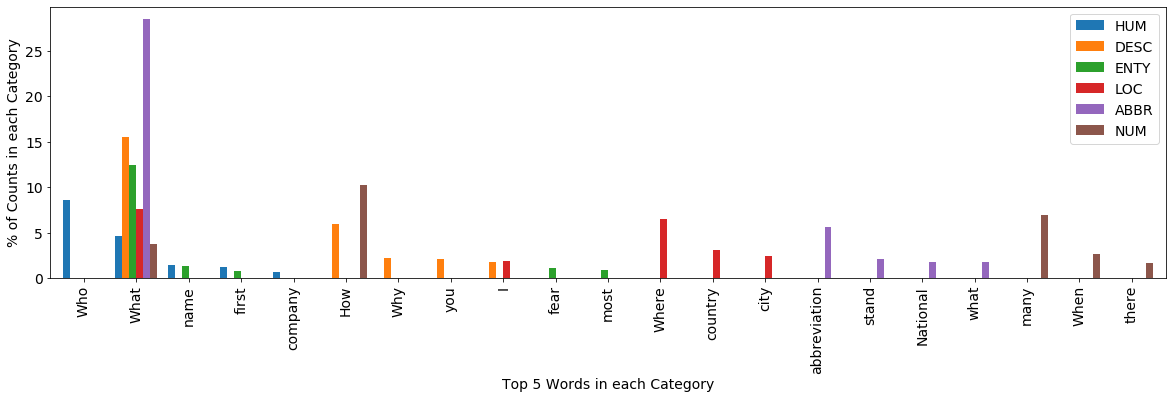

In [182]:
import matplotlib.pyplot as plt

df_word_count = pd.DataFrame(word_count)

df_word_top_five = pd.DataFrame()

for col in df_word_count.columns:
    df_word_top_five = pd.concat([df_word_top_five, df_word_count[col].
                               sort_values(ascending=False).head(5)/
                               df_word_count[col].sum()*100], axis=1, sort=False)


plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams.update({'font.size': 14})
df_word_top_five.plot.bar(width=0.8)
plt.xlabel('Top 5 Words in each Category')
plt.ylabel('% of Counts in each Category')
plt.xticks()
plt.show()

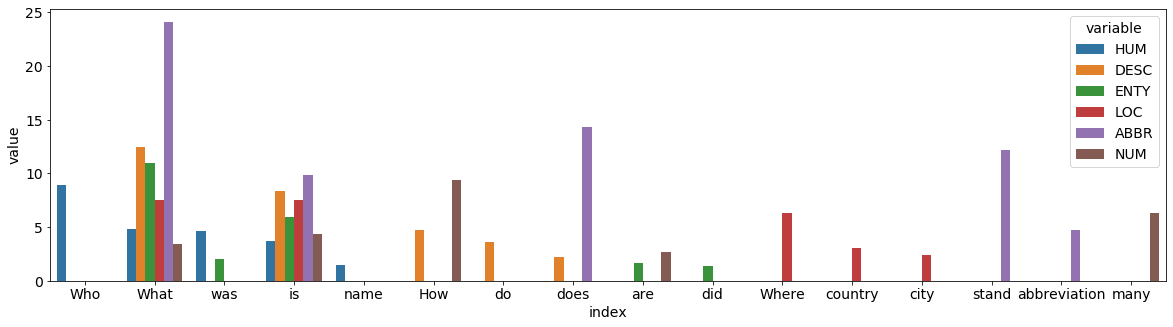

In [150]:
import seaborn as sns

df_tidy = pd.melt(df_word_top_five.reset_index(), id_vars='index')
sns.barplot(x='index', y='value', hue='variable', data=df_tidy)
plt.show()

In [256]:
df_label_dummy = pd.get_dummies(df.label)
df_vec_label = pd.concat([df_vec, df_label_dummy], axis=1)
df_vec_label_corr = df_vec_label.corr(method='pearson')
#df_vec_label_corr.style.background_gradient(cmap='coolwarm', axis=None)

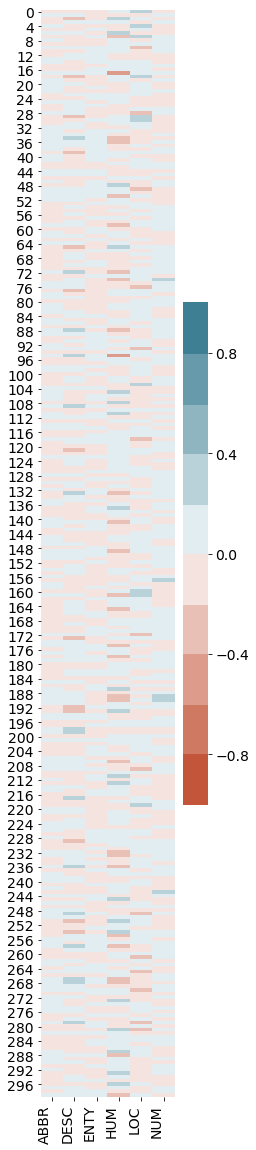

In [255]:
fig, ax = plt.subplots(figsize=(3,20))

ax = sns.heatmap(
    df_vec_label_corr_sliced, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=10),
    square=False, ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);